<a href="https://colab.research.google.com/github/ananyasketch/Rythmic-Chatbot-Song-Recommender/blob/main/Fake_Review_Monitoring_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake Review Monitoring System

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.9 MB/s 
     |████████████████████████████████| 182 kB 82.1 MB/s 
     |████████████████████████████████| 7.6 MB 61.4 MB/s 


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from nltk.tokenize import word_tokenize
from transformers import pipeline,BertModel, BertTokenizer
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
import re, string, unicodedata
from string import punctuation
from textblob import Word
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.stem import PorterStemmer


from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report, f1_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from keras.preprocessing.text import Tokenizer


/usr/local/lib/python3.8/dist-packages/wordcloud/wordcloud.py:35: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.8/dist-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def prediction(X_test, model_object):
    y_pred = model_object.predict(X_test)
    # print("Model : ",model_object)
    return y_pred


def cal_accuracy(y_test, y_pred, model_obj, X_test):

    print("\n\nConfusion Matrix: \n",
        confusion_matrix(y_test, y_pred))

    ac = accuracy_score(y_test,y_pred)*100
    print("\nAccuracy : ",ac,"\n\n")
    plot_confusion_matrix(model_obj, X_test, y_test)
    print(classification_report(y_test, y_pred))
    return round(ac, 3)


def train_and_predict(X_train, X_test, y_train, y_test, model_obj, model_name, df):
    model_obj.fit(X_train, y_train)
    y_pred= prediction(X_test, model_obj)
    ac=cal_accuracy(y_test, y_pred, model_obj, X_test)
    df[str(model_name)]=y_pred
    return df,ac

In [ ]:
constraints =['#B34D22','#EBE00C','#1FEB0C','#0C92EB','#EB0CD5']


def categorical_variable_summary(df,column_name):
    fig=make_subplots(rows=1,cols=2,
                      subplot_titles=('Countplot','Percentage'),
                      specs=[[{"type": "xy"},{'type':'domain'}]])

    fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                        x=[str(i) for i in df[column_name].value_counts().index],
                        text=df[column_name].value_counts().values.tolist(),
                        textfont=dict(size=15),
                        name=column_name,
                        textposition='auto',
                        showlegend=False,
                        marker=dict(color=constraints,
                                    line=dict(color='#DBE6EC',
                                              width=1))),
                  row=1,col=1)

    fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                        values=df[column_name].value_counts().values,
                        textfont=dict(size=20),
                        textposition='auto',
                        showlegend=False,
                        name=column_name,
                        marker=dict(colors=constraints)),
                 row=1,col=2)

    fig.update_layout(title={'text':column_name,
                            'y':0.9,
                            'x':0.5,
                            'xanchor':'center',
                            'yanchor':'top'},
                     template='plotly_white')
    iplot(fig)

\
**Loading Data**

In [ ]:
df=pd.read_csv("org_dataset.csv")
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,timestamp,IP Address
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,82850235.0,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",8/31/2015,1.440988e+09,193.93.167.87
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,82850235.0,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,8/31/2015,1.441002e+09,193.93.167.87
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235.0,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,8/31/2015,1.440959e+09,193.93.167.87
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,82850235.0,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well,Work very well,8/31/2015,1.441015e+09,193.93.167.87
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445.0,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",8/31/2015,1.440973e+09,205.10.168.66


\
Graph: Frequency of No. of helpful votes on a review

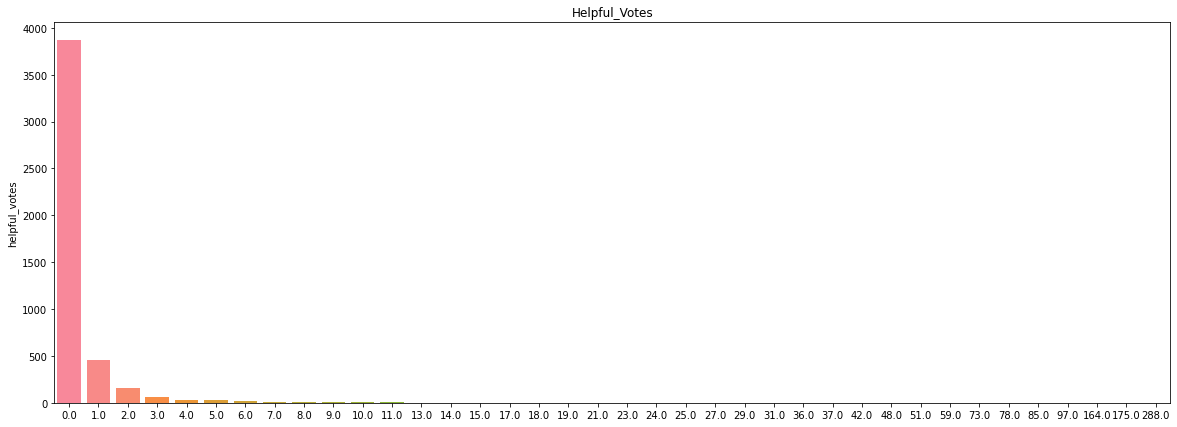

In [ ]:
plt.figure(figsize = [20, 7], clear = True, facecolor = 'white')

sns.barplot(x = df["helpful_votes"].value_counts().index,
            y = df["helpful_votes"].value_counts(),
            saturation = 1).set(title = "Helpful_Votes");

\
Graph: Distribution of Reviews Per Score

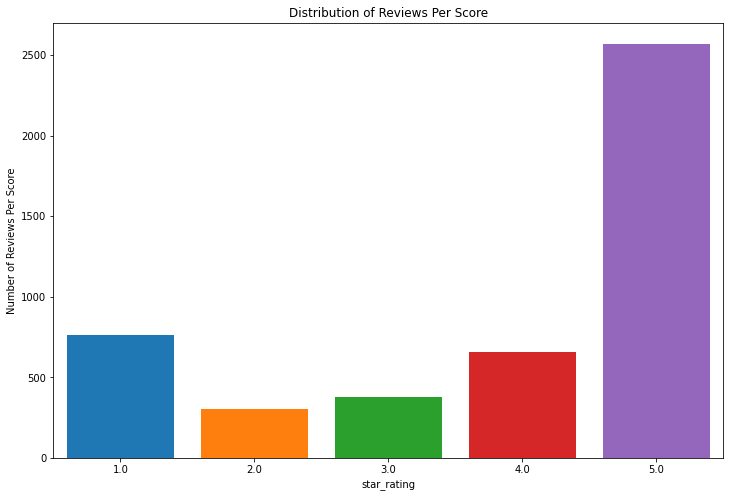

In [ ]:
plt.figure(figsize = [12, 8], clear = True, facecolor = 'white')
sns.barplot(x = df["star_rating"].value_counts().index,
            y = df["star_rating"].value_counts(),
            saturation = 1);
plt.xlabel("star_rating")
plt.ylabel("Number of Reviews Per Score")
plt.title("Distribution of Reviews Per Score")
plt.show()

\
Reviews over Time by Rating

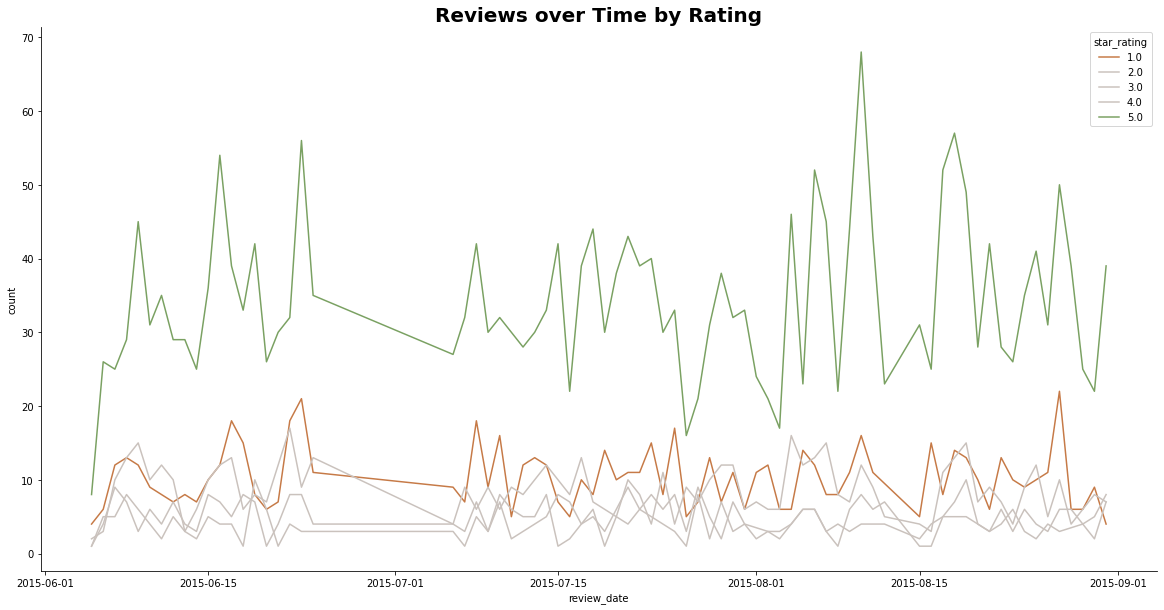

In [ ]:
df.review_date = pd.to_datetime(df.review_date)
df_rating_time = (df.groupby(['review_date', 'star_rating'])['review_id']
                  .count().to_frame().reset_index())
df_rating_time = df_rating_time.rename(columns={'review_id':'count'})

plt.figure(figsize=(20,10))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Reviews over Time by Rating', ha='center', fontsize=20,
          weight='bold')
sns.lineplot(data=df_rating_time, x='review_date', y='count',
             hue='star_rating', palette=['#C67A47', '#CAC2BD', '#CAC2BD',
                                         '#CAC2BD', '#7AA162']);

In [ ]:
df['star_rating'].value_counts()

5.0    2570
1.0     765
4.0     657
3.0     378
2.0     301
Name: star_rating, dtype: int64

\
Graph: Frequency of Verified Purchases

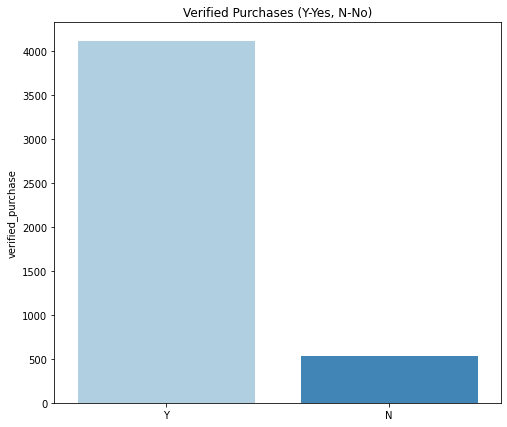

In [ ]:
plt.figure(figsize = [8, 7], clear = True)

sns.barplot(x = df["verified_purchase"].value_counts().index,
            y = df["verified_purchase"].value_counts(),palette = 'Blues', edgecolor = 'w',
            saturation = .85).set(title = "Verified Purchases (Y-Yes, N-No)");

\
Graph: Number of Reviews over time

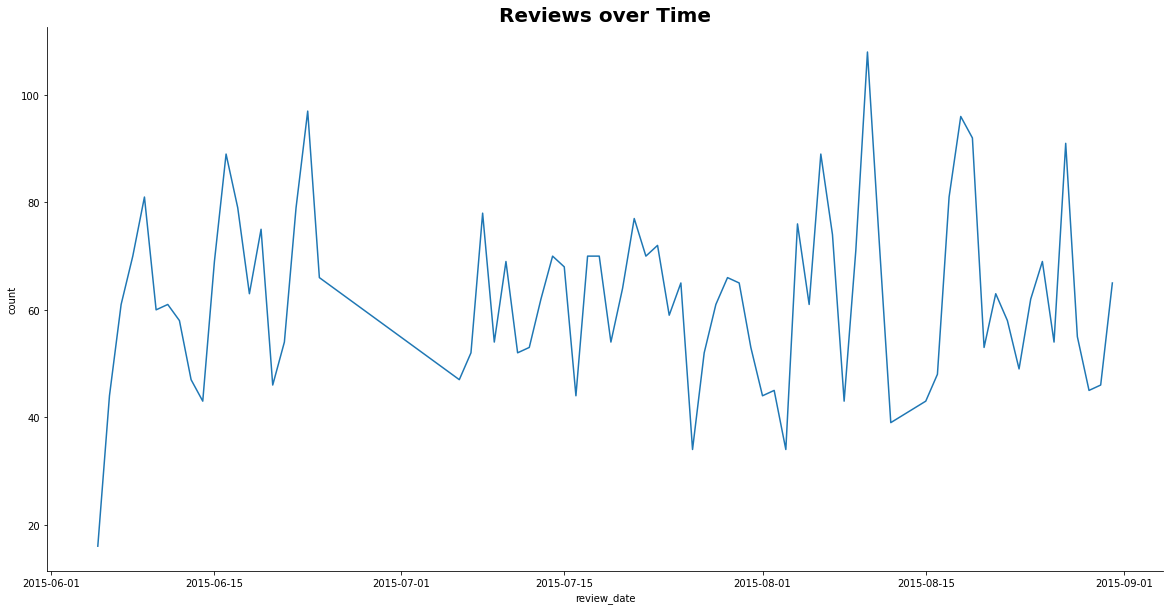

In [ ]:
df.review_date = pd.to_datetime(df.review_date)
df_review_count = (df.groupby('review_date')['review_id']
                   .count().to_frame().reset_index())
df_review_count = df_review_count.rename(columns={'review_id':'count'})
df_review_count.to_csv('df_review_count.csv', index=False)

plt.figure(figsize=(20,10))
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Reviews over Time', ha='center', fontsize=20,
          weight='bold')
sns.lineplot(data=df_review_count, x='review_date', y='count', palette = 'magma');

In [ ]:
df["review_date"]=pd.to_datetime(df["review_date"],dayfirst=True)
current_date=pd.to_datetime("2022-11-24")
df["days"] = (current_date - df["review_date"]).dt.days
df.days.describe().T
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,timestamp,IP Address,days
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,82850235.0,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31,1.440988e+09,193.93.167.87,2642.0
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,82850235.0,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31,1.441002e+09,193.93.167.87,2642.0
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235.0,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31,1.440959e+09,193.93.167.87,2642.0
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,82850235.0,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well,Work very well,2015-08-31,1.441015e+09,193.93.167.87,2642.0
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445.0,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31,1.440973e+09,205.10.168.66,2642.0


\
\
**Preprocessing Of DATA**

In [ ]:
def missing_values_analysis(df):
    na_columns_=[col for col in df.columns if df[col].isnull().sum() >0]
    n_miss=df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_=(df[na_columns_].isnull().sum() / df.shape[0]*100).sort_values(ascending=True)
    missing_df=pd.concat([n_miss, np.round(ratio_,2)],axis=1,keys=['Missing Values','Ratio'])
    missing_df=pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df ,head=5,tail=5):

    print("SHAPE".center(82,'~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print("Types".center(82,'~'))
    print(df.dtypes)
    print("".center(82,'~'))
    print(missing_values_analysis(df))
    print('DUPLICATED VALUES'.center(83,'~'))
    print(df.duplicated().sum())
    print('QUANTILES'.center(82,'~'))
    print(df.quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4672
Columns: 17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Types~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent       float64
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
timestamp            float64
IP Address            object
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                   Missing Values  Ratio
product_parent                  1   0.02
product_category                1   0.02
star_rating                     1   0.02
helpful_votes                   1   0.02
total_votes     

In [ ]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                              'Classes':[dataframe[i].nunique() \
                                         for i in dataframe.columns]})
    nunique_df = nunique_df.sort_values('Classes',ascending=False)
    nunique_df = nunique_df.reset_index(drop=True)
    return nunique_df
check_class(df)

,Variable,Classes
0,review_id,4664
1,customer_id,4593
2,review_body,4438
3,IP Address,4215
4,timestamp,4214
5,review_headline,2799
6,product_id,1974
7,product_title,1943
8,product_parent,1914
9,review_date,75


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,4672.0,2.393485e+07,1.654019e+07,29081.0,1.073941e+07,2.152710e+07,3.939036e+07,5.309619e+07
product_parent,4671.0,5.103115e+08,3.004910e+08,135186.0,2.345548e+08,5.363673e+08,7.540693e+08,9.991308e+08
star_rating,4671.0,3.849069e+00,1.529901e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
helpful_votes,4671.0,6.932134e-01,6.460908e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.880000e+02
total_votes,4671.0,1.033826e+00,8.060301e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2.940000e+02
timestamp,4223.0,1.436739e+09,3.136272e+07,5.0,1.434954e+09,1.437709e+09,1.439221e+09,1.441043e+09


In [ ]:
rt = lambda x: re.sub("[^a-zA-Z]",' ',str(x))
df["review_body"] = df["review_body"].map(rt)
df["review_body"] = df["review_body"].str.lower()
df.head(10)
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['review_body'] = df['review_body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])

In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace = True)

df["review_body"] = df["review_body"].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
df["review_body"]  = df["review_body"] .str.replace('[^\w\s]','')
df["review_body"] = df["review_body"].str.replace('\d','')

stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

df["review_body"] = df["review_body"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
df["review_body"] = df["review_body"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df["review_body"] = df["review_body"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

In [ ]:
###########################################################################################################################################

\
\
**Sentiment Analysis of Reviews and Headline**

In [ ]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def avg(dc):

    p,n,cp,cn=0,0,0,0
    x=classifier(dc)
    for i in (x):
      if(i['label']=='POSITIVE'):
        p+=i['score']
        cp+=1
      elif(i['label']=='NEGATIVE'):
        n+=i['score']
        cn+=1
    if(cn and cp):
      if((n/cn)>(p/cp)):
        return 'NEGATIVE', n/cn
      else:
        return 'POSITIVE', p/cp
    elif(cn):
      return 'NEGATIVE', n/cn
    elif(cp):
      return 'POSITIVE', p/cp
    else:
      return 'POSITIVE', 0

In [ ]:
df['review_body']=df['review_body'].apply(str)
df['review_headline']=df['review_headline'].apply(str)

In [ ]:
tokens_h= []
tokens_r= []
for i in range (len(df['review_body'])):
    tokens_h.append(word_tokenize(df['review_headline'][i]))
    tokens_r.append(word_tokenize(df['review_body'][i]))

In [ ]:
avg(tokens_r[1000])

('NEGATIVE', 0.9981153011322021)

In [ ]:
df.review_body[1000]

'Item received defective. No response from seller.'

In [ ]:
score_r=[] #Review body and sentiment
sentiment_r = [] #Run time: 1 hour
a=0
for i in tokens_r:
    o2 = avg(i)
    print(a, df.review_body[a], o2)
    sentiment_r.append(o2[0])
    score_r.append(o2[1])
    a+=1
df["r_sentiment"] = sentiment_r
df["r_score"] = score_r

0 advertised everything work perfectly happy camera matter fact going buy another one nd car ('NEGATIVE', 0.9583119750022888)
1 great ('POSITIVE', 0.9998630285263062)
2 work great fit life proof case iphone ('POSITIVE', 0.9864256680011749)
3 work well ('POSITIVE', 0.9995076060295105)
4 careful product bought several camera image pretty decent battery hold charge ('POSITIVE', 0.9641133606433868)
5 appears good still waiting item radio battery charger go star ('POSITIVE', 0.926186716556549)
6 first one arrived brick work charge useless exchanged new one work advertised ('NEGATIVE', 0.9997991919517517)
7 advertised everything work perfectly happy camera matter fact going buy another one nd car ('NEGATIVE', 0.9583119750022888)
8 advertised everything work perfectly happy camera matter fact going buy another one nd car ('NEGATIVE', 0.9583119750022888)
9 great ('POSITIVE', 0.9998630285263062)
10 work great fit life proof case iphone ('POSITIVE', 0.9864256680011749)
11 work well get used hear

In [ ]:
categorical_variable_summary(df,'r_sentiment')

In [ ]:
h_score=[] # Headline score and sentiment
h_sentiment=[] #Runtime: 5 min

for i in range (len(df["review_body"])):
    o1 = classifier(df["review_headline"][i])
    h_score.append(o1[0]['score'])
    h_sentiment.append(o1[0]['label'])

df["h_score"]=h_score
df["h_sentiment"] = h_sentiment


In [ ]:
classifier(df["review_headline"][134])

[{'label': 'POSITIVE', 'score': 0.9998695850372314}]

In [ ]:
categorical_variable_summary(df,'h_sentiment')

In [ ]:
out,s,sc=[],[],[]
for i in range (len(df["review_body"])):

    if(str(df["r_sentiment"][i])==str(df["h_sentiment"][i])):
       s.append(df["h_sentiment"][i])
       sc.append(h_score[i]*0.5+score_r[i]*0.5)
       out.append(0)
    else:
       out.append(1)
       x=h_score[i]-score_r[i]
       if(x>0):
           s.append(df["h_sentiment"][i])
       else:
           s.append(df["r_sentiment"][i])
       sc.append(abs(x))


df["same_dif"]=out
df["Sentiment"] = s
df["Score"] = sc

\
Graph: Frequency of Positive and Negative entries

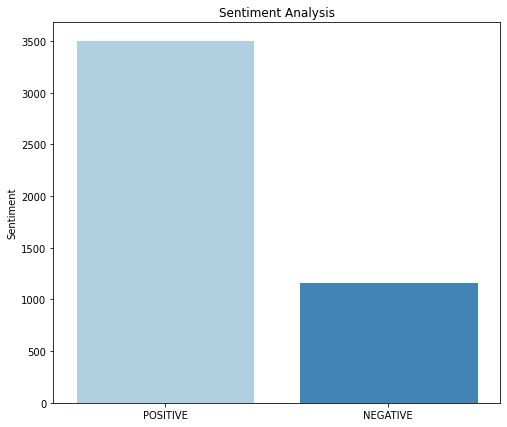

In [ ]:
plt.figure(figsize = [8, 7], clear = True)

sns.barplot(x = df["Sentiment"].value_counts().index,
            y = df["Sentiment"].value_counts(),palette = 'Blues', edgecolor = 'w',
            saturation = .85).set(title = "Sentiment Analysis");

In [ ]:
df["Sentiment"].value_counts()

POSITIVE    3506
NEGATIVE    1166
Name: Sentiment, dtype: int64

In [ ]:
df.to_csv("AllDetails.csv", index=False)
#########################################################################################################################################

\
**Categorizing Reviews into Fake/Original**

In [ ]:
df2=pd.read_csv('AllDetails.csv')
df2.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,...,timestamp,IP Address,days,r_sentiment,r_score,h_score,h_sentiment,same_dif,Sentiment,Score
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,82850235.0,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,...,1.440988e+09,193.93.167.87,2642.0,NEGATIVE,0.958312,0.999869,POSITIVE,1,POSITIVE,0.041557
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,82850235.0,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,...,1.441002e+09,193.93.167.87,2642.0,POSITIVE,0.999863,0.998510,POSITIVE,0,POSITIVE,0.999187
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235.0,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,...,1.440959e+09,193.93.167.87,2642.0,POSITIVE,0.986426,0.999485,POSITIVE,0,POSITIVE,0.992955
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,82850235.0,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,...,1.441015e+09,193.93.167.87,2642.0,POSITIVE,0.999508,0.999855,POSITIVE,0,POSITIVE,0.999681
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445.0,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,...,1.440973e+09,205.10.168.66,2642.0,POSITIVE,0.964113,0.996036,NEGATIVE,1,NEGATIVE,0.031923


In [ ]:
ar=[]
for i in range (len(df2['verified_purchase'])):
    ar.append('ORIGINAL')

df2["Result"] = ar

for i in range (len(df2['verified_purchase'])): #marked false if not a verifies purchase
    if df2['verified_purchase'][i] == 'N' :
      df2['Result'][i] = 'FAKE'

In [ ]:
df2['Result'].value_counts()

ORIGINAL    4123
FAKE         549
Name: Result, dtype: int64

In [ ]:
def form_str(data, df, i):
    string=""
    for col in data:
      string+=str(df[col][i])+'  '
    return string

In [ ]:
data=['timestamp','product_id', 'IP Address']
form_str(data, df2, 4)

'1440973308.0  B0067XVNTG  205.10.168.66  '

In [ ]:
def similarity (data, df, target):
    set1=set()
    for i in range(len(df)):
        s=form_str(data, df, i)
        if s not in set1:
            set1.add(s)

    dic2=dict()
    for j in set1:
        a=[]
        for i in range(len(df)):
            s=form_str(data, df, i)
            if(s==j):
                a.append(i)
        dic2[j]=a

    if (len(df)==len(dic2)):
        return
    else:
        for i in dic2.values():
            if(len(i)>1):
                for j in i:
                    df[target][j]='FAKE'

In [ ]:
data = ['IP Address', 'timestamp', 'product_id']
similarity(data, df2, 'Result') #Run time: 20 min
df2.Result.value_counts()

ORIGINAL    3950
FAKE         722
Name: Result, dtype: int64

In [ ]:
data = ['customer_id', 'timestamp']
similarity(data, df2, 'Result')#marked false if 2 rows have same customer_id and product_id
df2.Result.value_counts()

ORIGINAL    3936
FAKE         736
Name: Result, dtype: int64

In [ ]:
data = ['customer_id', 'product_id']
similarity(data, df2, 'Result') #Run time: 20 min
df2.Result.value_counts()

ORIGINAL    3935
FAKE         737
Name: Result, dtype: int64

In [ ]:
df2.to_csv("details_2.csv", index=False)
#******************************************************************************************************************************************

In [ ]:
df2=pd.read_csv('details_2.csv')
df2['Result'].value_counts()

ORIGINAL    3935
FAKE         737
Name: Result, dtype: int64

In [ ]:
for i in range (len(df2)):
    if(df2.r_score[i]==0 or len(tokens_r)<2):
        df2.Result[i]='FAKE'

df2.Result.value_counts()

ORIGINAL    3927
FAKE         745
Name: Result, dtype: int64

In [ ]:
for i in range (len(df2["review_body"])): #marked fake if sentiment of review and star_rating do not match
    if(df['star_rating'][i]!=3):
        if(str(df2['h_sentiment'][i])=='POSITIVE' and df2['star_rating'][i]<3 and str(df2['r_sentiment'][i])=='POSITIVE'):
            df2["Result"][i]="FAKE"
        elif(str(df2['h_sentiment'][i])=='NEGATIVE' and df2['star_rating'][i]>3 and str(df2['r_sentiment'][i])=='NEGATIVE'):
            df2["Result"][i]="FAKE"

df2['Result'].value_counts()

ORIGINAL    3768
FAKE         904
Name: Result, dtype: int64

In [ ]:
for i in range (len(df)):
    if (len(tokens_h[i])>12):
        df2["Result"][i]="FAKE"

df2['Result'].value_counts()

ORIGINAL    3550
FAKE        1122
Name: Result, dtype: int64

In [ ]:
for i in range (len(df2["review_body"])): #marked false if the review has more dislikes than likes
    if(df2['total_votes'][i]!=0 and df2['helpful_votes'][i]/df2['total_votes'][i]<0.4):
        df2['Result'][i]='FAKE'

df2['Result'].value_counts()

ORIGINAL    3316
FAKE        1356
Name: Result, dtype: int64

In [ ]:
for i in range(len(df2)): #marked fake if the review contains a meaningless story
    text = str(df2["review_body"][i]).lower()
    words = nltk.word_tokenize(text)
    sentence = nltk.sent_tokenize(text)
    count=0
    meaningless=["i", "we", "then", "br", "aa", "you"]
    if(len(sentence)):
        for j in range(len(words)):
            if words[j] in meaningless:
                count+=1
        if(count > len(sentence)):
            df2['Result'][i]='FAKE'

In [ ]:
df2.Result.value_counts()

ORIGINAL    3184
FAKE        1488
Name: Result, dtype: int64

In [ ]:
target=[] #storing data in a target column
for i in range (len(df2["Result"])):
    if(str(df2.Result[i]) == 'ORIGINAL'):
        target.append(1)
    elif(str(df2.Result[i]) == 'FAKE'):
        target.append(0)

df2['target'] = target

In [ ]:
categorical_variable_summary(df2, 'target')

\
Distribution of Fake/Original Reviews

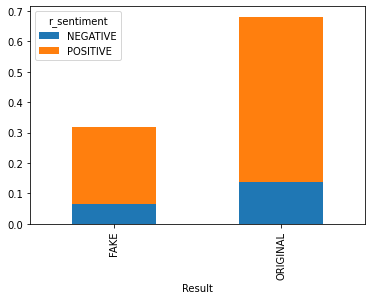

In [ ]:
pd.crosstab(df2['Result'], df2["r_sentiment"],
            normalize = True).plot(kind = "bar",
                                   backend = "matplotlib",
                                   legend = True, stacked=True);

In [ ]:
true_reviews=[] #Forming WordCloud for Fake and Original Reviews
false_reviews=[]

for i in range (len(df['review_body'])):
  if str(df2["Result"][i])=='ORIGINAL':
    true_reviews.append(df['review_body'][i])
  else:
    false_reviews.append(df['review_body'][i])

Most common words in Original Reviews

<function matplotlib.pyplot.show(*args, **kw)>

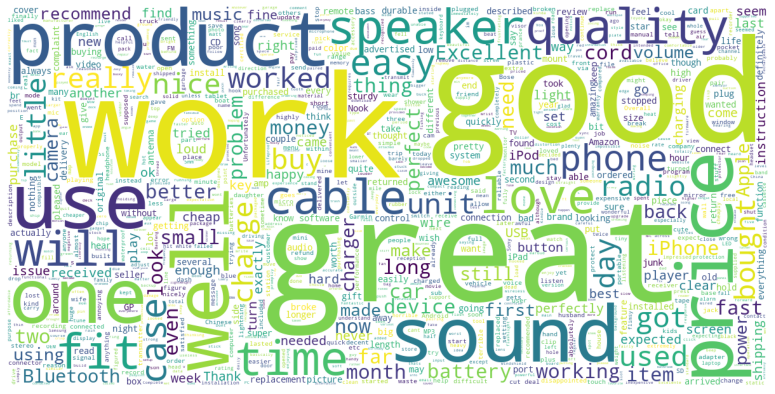

In [ ]:
text = " ".join(i for i in map(str, true_reviews))

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

Most common words in Fake Reviews

<function matplotlib.pyplot.show(*args, **kw)>

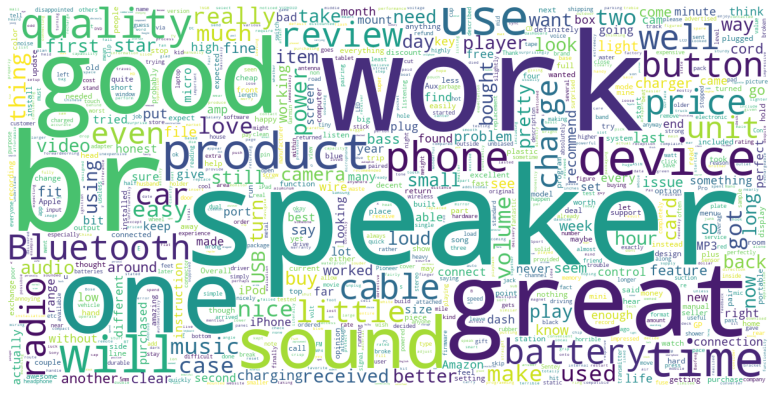

In [ ]:
text = " ".join(i for i in map(str, false_reviews))

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

\


In [ ]:
df2.to_csv("details_and_target.csv", index=False)
#########################################################################################################################################

Importing required csv files


In [ ]:
df1=pd.read_csv('details_and_target.csv')
df=pd.read_csv("org_dataset.csv")

Shuffled data added to a new dataframe

In [ ]:
data2=['review_headline', 'review_body','star_rating','verified_purchase','r_sentiment','h_sentiment','h_score','r_score','target']

In [ ]:
data2 = df1[data2]
data2.tail()

,review_headline,review_body,star_rating,verified_purchase,r_sentiment,h_sentiment,h_score,r_score,target
4667,Five Stars,fine working little radio easy program software,5.0,Y,POSITIVE,POSITIVE,0.999009,0.987929,1
4668,Five Stars,good reliable,5.0,Y,POSITIVE,POSITIVE,0.999009,0.999831,1
4669,quality product,needed work advertised never come,5.0,Y,NEGATIVE,POSITIVE,0.999740,0.990474,1
4670,Don't waste your money,awful claim apple certified another ty knock p...,1.0,Y,NEGATIVE,POSITIVE,0.960382,0.999516,1
4671,Easy transaction but product has unresolved de...,good price seller sought feedback unfortunatel...,3.0,Y,POSITIVE,NEGATIVE,0.987743,0.976959,1


In [ ]:
data2=data2.sample(frac=1, random_state=2).reset_index()
data2=data2.drop(['index'], axis=1)
data2.head()

,review_headline,review_body,star_rating,verified_purchase,r_sentiment,h_sentiment,h_score,r_score,target
0,Four Stars,work great,4.0,Y,POSITIVE,POSITIVE,0.999403,0.999654,1
1,Three Stars,cable lasted month working used car usb connec...,3.0,Y,POSITIVE,POSITIVE,0.999215,0.962320,0
2,Just what I was looking for. Didn't want to ...,looking want pay onstar navigation system want...,5.0,Y,POSITIVE,NEGATIVE,0.998874,0.992868,1
3,I love stitch a lot so I bought this case for ...,love stitch lot bought case ipod case tooooooo...,4.0,Y,POSITIVE,POSITIVE,0.918327,0.973087,1
4,I love the size and the kids are very impresse...,looking speaker kid use pool want phone get br...,5.0,N,POSITIVE,POSITIVE,0.999886,0.985509,0


In [ ]:
data2.to_csv("dataset.csv", index=False)

\




In [ ]:
le = LabelEncoder()
df = pd.read_csv("dataset.csv")
df = df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

target_name = "target"
target = df[target_name]
data = df.drop(columns=[target_name])

In [ ]:
data.head()

,review_headline,review_body,star_rating,verified_purchase,r_sentiment,h_sentiment,h_score,r_score
0,632,3847,3,1,1,1,1241,3704
1,2080,467,2,1,1,1,1165,482
2,1310,2150,4,1,1,0,1059,2412
3,1113,2240,3,1,1,1,166,946
4,1118,2149,4,0,1,1,2287,1760


In [ ]:
target

0       1
1       0
2       1
3       1
4       0
       ..
4667    1
4668    1
4669    1
4670    0
4671    1
Name: target, Length: 4672, dtype: int64

In [ ]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(data, target, random_state=300)

In [ ]:
len(data_train)/len(data2)

0.75

In [ ]:
Test = pd.DataFrame(target_test).reset_index()
Test.drop('index', axis=1, inplace = True)
Test.head()

,target
0,0
1,1
2,0
3,0
4,1


\
Logistic Regression



Confusion Matrix: 
 [[147 224]
 [ 14 783]]

Accuracy :  79.62328767123287 


              precision    recall  f1-score   support

           0       0.91      0.40      0.55       371
           1       0.78      0.98      0.87       797

    accuracy                           0.80      1168
   macro avg       0.85      0.69      0.71      1168
weighted avg       0.82      0.80      0.77      1168



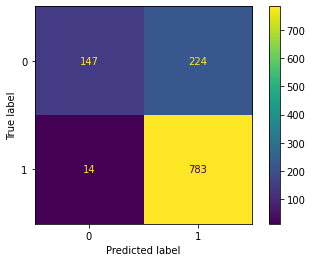

In [ ]:
model1 = make_pipeline(preprocessor, LogisticRegression(max_iter=500))

Test, a1 = train_and_predict(data_train, data_test, target_train, target_test, model1, 'LR', Test)

\
Decision Tree Classifier



Confusion Matrix: 
 [[182 189]
 [  5 792]]

Accuracy :  83.3904109589041 


              precision    recall  f1-score   support

           0       0.97      0.49      0.65       371
           1       0.81      0.99      0.89       797

    accuracy                           0.83      1168
   macro avg       0.89      0.74      0.77      1168
weighted avg       0.86      0.83      0.82      1168



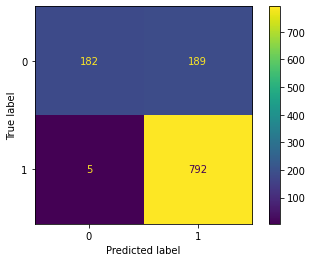

In [ ]:

model2 = make_pipeline(preprocessor, DecisionTreeClassifier(
            criterion = "entropy", random_state = 300,
            max_depth = 5, min_samples_leaf = 1))

Test, a2 = train_and_predict(data_train, data_test, target_train, target_test, model2, 'DTC', Test)

\
Random Forest Classifier



Confusion Matrix: 
 [[205 166]
 [ 46 751]]

Accuracy :  81.84931506849315 


              precision    recall  f1-score   support

           0       0.82      0.55      0.66       371
           1       0.82      0.94      0.88       797

    accuracy                           0.82      1168
   macro avg       0.82      0.75      0.77      1168
weighted avg       0.82      0.82      0.81      1168



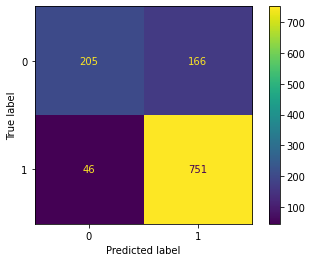

In [ ]:
model3 = make_pipeline(preprocessor, RandomForestClassifier())

Test, a3 = train_and_predict(data_train, data_test, target_train, target_test, model3, 'RFC', Test)

\
K-Nearest Neighbors



Confusion Matrix: 
 [[197 174]
 [ 55 742]]

Accuracy :  80.39383561643835 


              precision    recall  f1-score   support

           0       0.78      0.53      0.63       371
           1       0.81      0.93      0.87       797

    accuracy                           0.80      1168
   macro avg       0.80      0.73      0.75      1168
weighted avg       0.80      0.80      0.79      1168



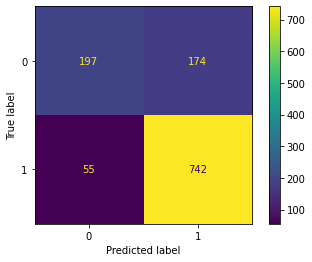

In [ ]:
model4 = make_pipeline(preprocessor, KNeighborsClassifier())

Test, a4 = train_and_predict(data_train, data_test, target_train, target_test, model4, 'KNN', Test)

\
Naive Bayes



Confusion Matrix: 
 [[166 205]
 [ 60 737]]

Accuracy :  77.31164383561644 


              precision    recall  f1-score   support

           0       0.73      0.45      0.56       371
           1       0.78      0.92      0.85       797

    accuracy                           0.77      1168
   macro avg       0.76      0.69      0.70      1168
weighted avg       0.77      0.77      0.76      1168



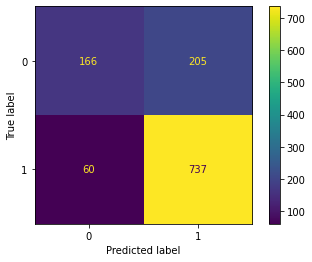

In [ ]:
model5 = make_pipeline(preprocessor, BernoulliNB())

Test, a5 = train_and_predict(data_train, data_test, target_train, target_test, model5, 'NB', Test)

In [ ]:
Test[:10]

,target,LR,DTC,En_st,RFC,KNN,NB
0,0,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0
8,1,1,1,1,0,1,1
9,0,0,0,0,0,0,0


\
Ensemble Learning - Voting



Confusion Matrix: 
 [[187 184]
 [ 14 783]]

Accuracy :  83.04794520547945 


              precision    recall  f1-score   support

           0       0.93      0.50      0.65       371
           1       0.81      0.98      0.89       797

    accuracy                           0.83      1168
   macro avg       0.87      0.74      0.77      1168
weighted avg       0.85      0.83      0.81      1168



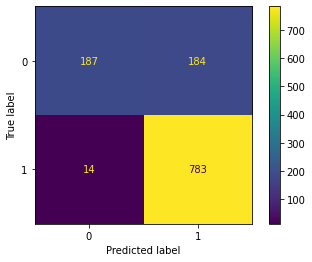

In [ ]:
voting_clf = VotingClassifier(estimators=[('LR', model1), ('DT', model2), ('RF', model3), ('KNN', model4), ('NB', model5),], voting='hard')
model6=voting_clf.fit(data_train, target_train)
Test, a6 = train_and_predict(data_train, data_test, target_train, target_test, model6, 'En_v', Test)

\
Ensemble Learning - Stacking



Confusion Matrix: 
 [[203 168]
 [ 26 771]]

Accuracy :  83.3904109589041 


              precision    recall  f1-score   support

           0       0.89      0.55      0.68       371
           1       0.82      0.97      0.89       797

    accuracy                           0.83      1168
   macro avg       0.85      0.76      0.78      1168
weighted avg       0.84      0.83      0.82      1168



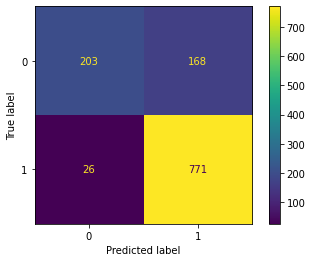

In [ ]:
from sklearn.ensemble import StackingClassifier
estimators=[('LR', model1), ('DT', model2), ('RF', model3), ('KNN', model4), ('NB', model5),]

stack_model = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression())
model7 = stack_model.fit(data_train, target_train)
Test, a7 = train_and_predict(data_train, data_test, target_train, target_test, model7, 'En_st', Test)

In [ ]:
Test[:10]

,target,LR,DTC,En_st,RFC,KNN,NB,En_v
0,0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0
8,1,1,1,1,0,1,1,1
9,0,0,0,0,0,0,0,0


In [ ]:
Test.to_csv("Predictions.csv", index=False)

\
**Models and their Accuracy**

In [ ]:
Models = ['Logistic Regression', "Decision Tree Classifier", "Random Forest Classifier", "K-Nearest Neighbors", "Naive Bayes", "Ensemble Learning-Voting", "Ensemble Learning-Stacking"] #, "Support Vector Machine"]
acc = [a1, a2, a3, a4, a5, a6, a7]
Result=pd.DataFrame({'Models': Models, 'Accuracy(%)': acc})
Result.to_csv('Results.csv')
Result

,Models,Accuracy(%)
0,Logistic Regression,79.623
1,Decision Tree Classifier,83.390
2,Random Forest Classifier,81.849
3,K-Nearest Neighbors,80.394
4,Naive Bayes,77.312
5,Ensemble Learning-Voting,83.048
6,Ensemble Learning-Stacking,83.390


\
**Graph: Model Vs Accuracy**

Text(0.5, 1.0, 'Accuracy of different Classification Algorithims')

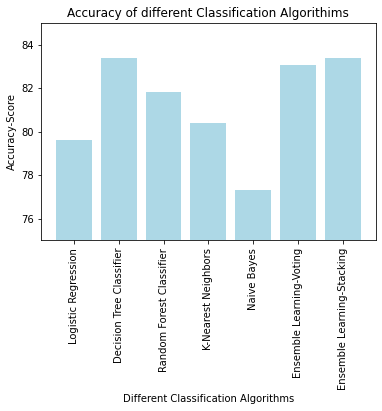

In [ ]:
x_axis = np.array(Models)
y_axis = np.array([a1, a2, a3, a4, a5, a6, a7])
fig, ax = plt.subplots()
plt.bar(x_axis,y_axis,width=0.8,color='lightblue',);
plt.xticks(rotation = 90)
ax.set(ylim=[75, 85])
plt.xlabel("Different Classification Algorithms")
plt.ylabel("Accuracy-Score")
plt.title("Accuracy of different Classification Algorithims")

\
**Correlation Matrix**

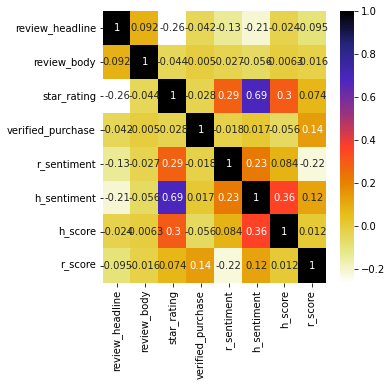

In [ ]:
plt.figure(figsize=(5,5))
cor=data_train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

\
\
**Cross Validation**

In [ ]:
cv_a, cv_p, cv_r, cv_f1  = [], [], [], []
models = [model1, model2, model3, model4, model5, model6, model7]
for i in models:
    cv_a.append(np.mean((cross_val_score(i, data, target,cv=5, scoring="accuracy"))))
    cv_p.append(np.mean((cross_val_score(i, data, target,cv=5, scoring="precision"))))
    cv_r.append(np.mean((cross_val_score(i, data, target,cv=5, scoring="recall"))))
    cv_f1.append(np.mean((cross_val_score(i, data, target,cv=5, scoring="f1"))))


In [ ]:
cv_a.append(np.mean(cv_a))
cv_p.append(np.mean(cv_p))
cv_r.append(np.mean(cv_r))
cv_f1.append(np.mean(cv_f1))

In [ ]:
Models.append('Mean')

In [ ]:
Cross_Validation=pd.DataFrame({'Models': Models, 'Accuracy': cv_a, 'Precision': cv_p, 'Recall': cv_r, 'f1':cv_f1})
Cross_Validation.to_csv('Cross_Validation.csv')
Cross_Validation

,Models,Accuracy,Precision,Recall,f1
0,Logistic Regression,0.796021,0.773374,0.991208,0.868827
1,Decision Tree Classifier,0.822351,0.797684,0.990579,0.883711
2,Random Forest Classifier,0.821062,0.817057,0.952887,0.881770
3,K-Nearest Neighbors,0.809290,0.812846,0.935614,0.869908
4,Naive Bayes,0.779537,0.781528,0.939069,0.853055
5,Ensemble Learning-Voting,0.819781,0.795989,0.988379,0.882332
6,Ensemble Learning-Stacking,0.827913,0.812890,0.971731,0.884050
7,Mean,0.810851,0.798767,0.967067,0.874807


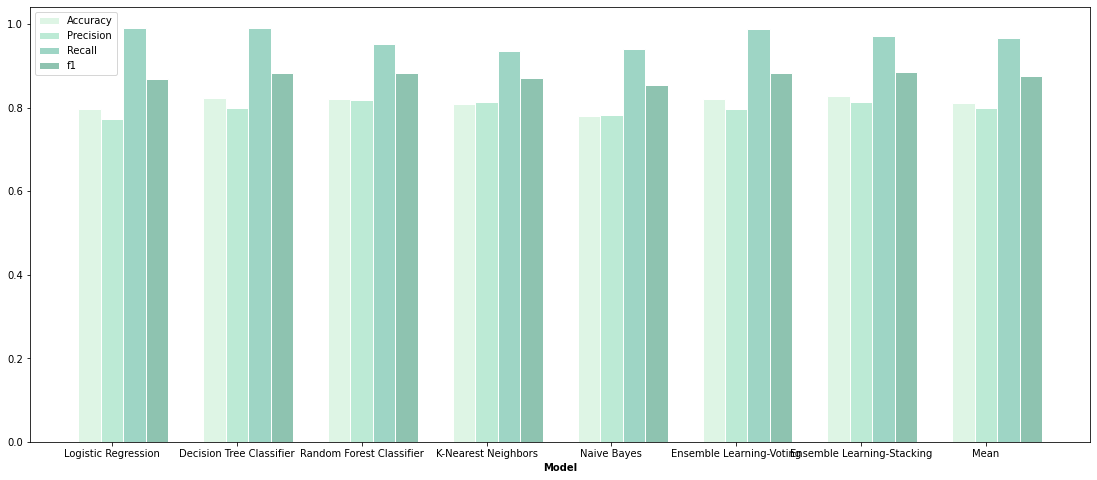

In [ ]:
barWidth = 0.18
r1 = np.arange(len(cv_a))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
plt.figure(figsize=(19,8))
plt.bar(r1, cv_a, color='#DEF5E5', width=barWidth, edgecolor='white', label='Accuracy')
plt.bar(r2, cv_p, color='#BCEAD5', width=barWidth, edgecolor='white', label='Precision')
plt.bar(r3, cv_r, color='#9ED5C5', width=barWidth, edgecolor='white', label='Recall')
plt.bar(r4, cv_f1, color='#8EC3B0', width=barWidth, edgecolor='white', label='f1')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(cv_f1))], Models)

plt.legend()